<a href="https://colab.research.google.com/github/dcatrib/tesePython/blob/main/Testes_Previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyMuPDF requests selenium chromedriver-autoinstaller pandas nltk gensim numpy skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [2]:
import requests
import os
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from google.colab import files
import numpy as np
from gensim.models import KeyedVectors, Word2Vec
import gensim
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

In [3]:
# Faça o upload do arquivo
uploaded = files.upload()

# Carregando o arquivo Excel corretamente
df_final = pd.read_excel('corpus.xlsx')  # Corrigido para corpus.xlsx


# Extraindo a quarta coluna como corpus (fazendo limpeza de valores não-texto)
corpus = df_final.iloc[:, 12].dropna().tolist()  # Remove valores NaN

corpus = [text for text in corpus if isinstance(text, str) and text.strip() != ""]

# Pré-processamento do texto (divisão em palavras)
# Aqui estamos usando um simples split, mas você pode querer fazer mais pré-processamento
corpus_tokenized = [text.split() for text in corpus]

# Word2Vec (cbow)
print("Treinando Word2Vec...")
word2vec_model = gensim.models.Word2Vec(corpus_tokenized, vector_size=300, window=5, min_count=1, workers=4)
print(df_final.head(20))

Saving corpus.xlsx to corpus.xlsx
Treinando Word2Vec...
   trimestre                                               Link  \
0     2003Q2  https://www.bcb.gov.br/en/publications/copommi...   
1     2003Q3  https://www.bcb.gov.br/en/publications/copommi...   
2     2003Q4  https://www.bcb.gov.br/en/publications/copommi...   
3     2004Q1  https://www.bcb.gov.br/en/publications/copommi...   
4     2004Q2  https://www.bcb.gov.br/en/publications/copommi...   
5     2004Q3  https://www.bcb.gov.br/en/publications/copommi...   
6     2004Q4  https://www.bcb.gov.br/en/publications/copommi...   
7     2005Q1  https://www.bcb.gov.br/en/publications/copommi...   
8     2005Q2  https://www.bcb.gov.br/en/publications/copommi...   
9     2005Q3  https://www.bcb.gov.br/en/publications/copommi...   
10    2005Q4  https://www.bcb.gov.br/en/publications/copommi...   
11    2006Q1  https://www.bcb.gov.br/en/publications/copommi...   
12    2006Q2  https://www.bcb.gov.br/en/publications/copommi...   
13    

['recent evolution inflation measures inflation continued downward trend wholesale prices fell mainly due effects recent exchange rate appreciation especially prices tradable goods consumer prices average decelerating although slower rate wholesale level reflecting pressures specific items ipca increased comparison previous accumulating months igpdi decreased compared increase ipadi fell comparison previous igp di ipadi fell consecutive totaling respectively comparison regarding evolution ipca average increase electricity due increases household electricity tariffs public lighting taxes capitals largest single contribution increase ipca increase price rice contributed significantly ipca inflation inflation market regulated prices ipca slowed increase market prices fell due deceleration inflation nontradable goods prices remained stable mainly due declines prices perishable foods increase service prices slowdown inflation tradable goods prices intense prices rising compared continuing u

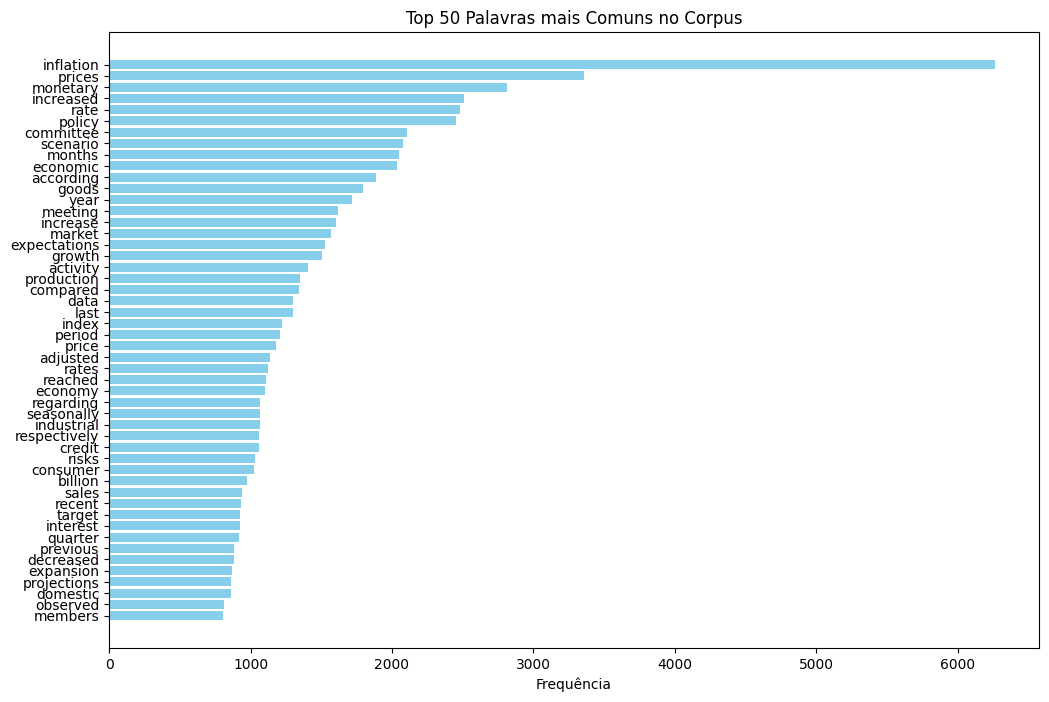


Estatísticas adicionais:
Total de palavras: 276002
Total de palavras únicas: 5693
Comprimento médio das palavras: 7.52 caracteres


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
print(corpus[:3])  # Exibe as 3 primeiras amostras processadas

# Flatten the list of tokenized words (corpus_tokenized)
flat_corpus = [word for sublist in corpus_tokenized for word in sublist]

# Contar a frequência de palavras
word_freq = Counter(flat_corpus)

# Obter as 20 palavras mais comuns e suas frequências
top_50_words = word_freq.most_common(50)

# Exibindo as 20 palavras mais comuns
print("As 50 palavras mais comuns:")
for word, freq in top_50_words:
    print(f"{word}: {freq}")

# Visualizar as 20 palavras mais comuns com um gráfico
words, freqs = zip(*top_50_words)
plt.figure(figsize=(12, 8))
plt.barh(words, freqs, color='skyblue')
plt.xlabel('Frequência')
plt.title('Top 50 Palavras mais Comuns no Corpus')
plt.gca().invert_yaxis()  # Para as palavras mais frequentes ficarem no topo
plt.show()

# Outras estatísticas
total_palavras = len(flat_corpus)
total_palavras_unicas = len(word_freq)
comprimento_medio_palavra = np.mean([len(word) for word in flat_corpus])

print(f"\nEstatísticas adicionais:")
print(f"Total de palavras: {total_palavras}")
print(f"Total de palavras únicas: {total_palavras_unicas}")
print(f"Comprimento médio das palavras: {comprimento_medio_palavra:.2f} caracteres")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['recent', 'evolution', 'inflation', 'measures', 'inflation', 'continued', 'downward', 'trend', 'wholesale', 'prices', 'fell', 'mainly', 'due', 'effects', 'recent', 'exchange', 'rate', 'appreciation', 'especially', 'prices', 'tradable', 'goods', 'consumer', 'prices', 'average', 'decelerating', 'although', 'slower', 'rate', 'wholesale', 'level', 'reflecting', 'pressures', 'specific', 'items', 'ipca', 'increased', 'comparison', 'previous', 'accumulating', 'months', 'igpdi', 'decreased', 'compared', 'increase', 'ipadi', 'fell', 'comparison', 'previous', 'igp']


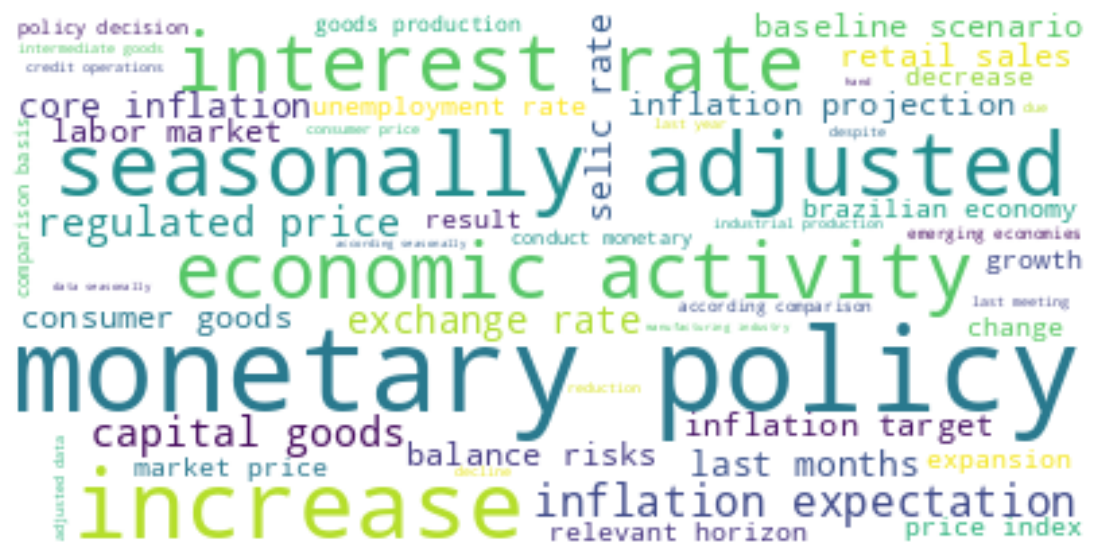

In [ ]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Download the 'punkt' resource for tokenization
nltk.download('punkt_tab')

text = " ".join(corpus)

# Tokenize the text into individual words using NLTK
tokens = word_tokenize(text)
print(tokens[:50])  # Print the first 50 tokens

# Join the tokens back into a string
text_for_wordcloud = " ".join(tokens)

# Generate the word cloud with the tokenized text
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text_for_wordcloud) #com frases
#wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text_for_wordcloud)

plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the 'vader_lexicon' resource
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# Convert the 'Texto Processado2' column to strings, handling NaN values
df_final['Texto Processado2'] = df_final['Texto Processado2'].astype(str)

df_final['polarity'] = df_final['Texto Processado2'].apply(lambda x: analyzer.polarity_scores(x))


# Change data structure
df_final = pd.concat(
    [df_final.drop(['polarity'], axis=1),
     df_final['polarity'].apply(pd.Series)], axis=1)
df_final.head(4)
# Create new variable with sentiment "neutral," "positive" and "negative"
df_final['sentiment'] = df_final['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df_final.head(4)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,trimestre,Link,Texto,Link de Download,Texto do PDF,Texto Processado,Ano_Mes,A,B,C,D,Footnotes,Texto Processado2,PIB_Taxa_Trimestral,PIB_Trimestre_Contra_Trimestre,neg,neu,pos,compound,sentiment
0,2003Q2,https://www.bcb.gov.br/en/publications/copommi...,85th Copom minutes - June 2003 84th Copom minu...,https://www.bcb.gov.br/content/copom/copomminu...,Minutes of the 85th Meeting of the Monetary Po...,recent evolution inflation measures inflation ...,2003-06 2003-05,nan nan,nan nan,nan nan,nan nan,nan nan,recent evolution inflation measures inflation ...,0.781242,-0.834888,0.063,0.758,0.178,0.9999,positive
1,2003Q3,https://www.bcb.gov.br/en/publications/copommi...,88th Copom minutes - September 2003 87th Copom...,https://www.bcb.gov.br/content/copom/copomminu...,1 Minutes of the 88th Meeting of the Monetary ...,recent evolution inflation ipca increased incr...,2003-09 2003-08 2003-07,nan nan nan,nan nan nan,nan nan nan,nan nan nan,nan nan nan,recent evolution inflation ipca increased incr...,0.626181,0.841633,0.053,0.774,0.173,0.9999,positive
2,2003Q4,https://www.bcb.gov.br/en/publications/copommi...,91st Copom minutes - December 2003 90th Copom ...,https://www.bcb.gov.br/content/copom/copomminu...,Minutes of the 91st Meeting of the Monetary Po...,recent evolution inflation main inflation indi...,2003-12 2003-11 2003-10,nan nan nan,nan nan nan,nan nan nan,nan nan nan,nan nan nan,recent evolution inflation main inflation indi...,0.588712,1.034545,0.051,0.747,0.201,1.0000,positive
3,2004Q1,https://www.bcb.gov.br/en/publications/copommi...,94th Copom minutes - March 2004 93rd Copom min...,https://www.bcb.gov.br/content/copom/copomminu...,Minutes of the 94th Meeting of the Monetary Po...,recent evolution inflation price deceleration ...,2004-03 2004-02 2004-01,nan nan nan,nan nan nan,nan nan nan,nan nan nan,nan nan nan,recent evolution inflation price deceleration ...,3.878082,1.487211,0.063,0.782,0.155,0.9999,positive


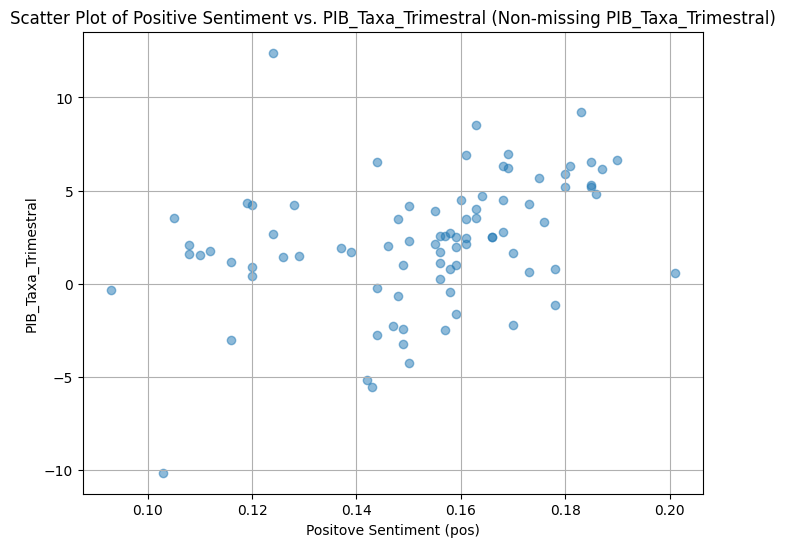

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows where 'Valor' is not missing
filtered_df = df_final

# Extract the 'neg' and 'Valor' columns from the filtered DataFrame
pos_values = filtered_df['pos']
valor_values = filtered_df['PIB_Taxa_Trimestral']

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(pos_values, valor_values, alpha=0.5)  # alpha controls point transparency
plt.xlabel("Positove Sentiment (pos)")
plt.ylabel("PIB_Taxa_Trimestral")
plt.title("Scatter Plot of Positive Sentiment vs. PIB_Taxa_Trimestral (Non-missing PIB_Taxa_Trimestral)")
plt.grid(True)  # Add a grid for better visualization
plt.show()

In [4]:
# Função para obter o vetor médio
def get_average_vector(text):
    if isinstance(text, str):  # Verifica se o texto é uma string
        words = text.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
    return np.zeros(word2vec_model.vector_size)  # Retorna vetor zero se não houver palavras válidas ou se o texto não for string

# Criar a nova coluna 'Texto Processado'
df_final['Vetor Médio'] = df_final['Texto Processado2'].apply(get_average_vector)

   trimestre                                               Link  \
0     2003Q2  https://www.bcb.gov.br/en/publications/copommi...   
1     2003Q3  https://www.bcb.gov.br/en/publications/copommi...   
2     2003Q4  https://www.bcb.gov.br/en/publications/copommi...   
3     2004Q1  https://www.bcb.gov.br/en/publications/copommi...   
4     2004Q2  https://www.bcb.gov.br/en/publications/copommi...   
..       ...                                                ...   
82    2023Q4  https://www.bcb.gov.br/en/publications/copommi...   
83    2024Q1  https://www.bcb.gov.br/en/publications/copommi...   
84    2024Q2  https://www.bcb.gov.br/en/publications/copommi...   
85    2024Q3  https://www.bcb.gov.br/en/publications/copommi...   
86    2024Q4  https://www.bcb.gov.br/en/publications/copommi...   

                                                Texto  \
0   85th Copom minutes - June 2003 84th Copom minu...   
1   88th Copom minutes - September 2003 87th Copom...   
2   91st Copom minutes -

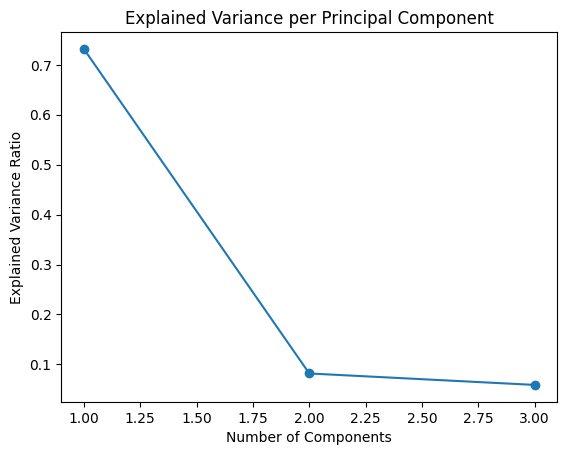

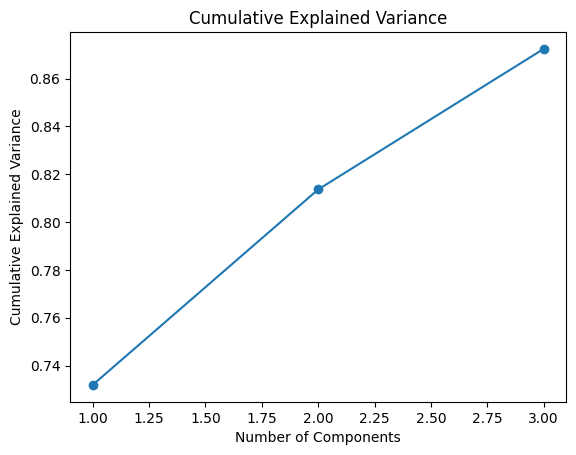

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separar as features e o target
X = df_final['Vetor Médio'].to_list()
X = np.array(X)

# Escalonar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=3)  # Ajustar o número de componentes conforme necessário
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=X_pca,
                             columns=['PC' + str(i) for i in range(1, pca.n_components_ + 1)],
                             index=df_final.index)  # Use original index

# Concatenate the principal components with the original DataFrame
df_final_pca = pd.concat([df_final, principal_df], axis=1)
df_final_pca['PCA'] = X_pca.tolist()

print(df_final_pca)

# Get explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Print explained variance ratio
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print cumulative explained variance
print("\nCumulative Explained Variance:")
for i, variance in enumerate(cumulative_variance):
    print(f"PC{i+1}: {variance:.4f}")

# Plot explained variance
import matplotlib.pyplot as plt
plt.plot(range(1, pca.n_components_ + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance per Principal Component')
plt.show()

# Plot cumulative explained variance
plt.plot(range(1, pca.n_components_ + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

AR2 MSE: 1.0309452778340154
LinearRegression MSE: 11.360648507327666
   trimestre  Valor_Atual  AR2_Previsto  LinearRegression_Previsto
42   2013-4T          3.0      2.898389                   3.360445
43   2014-1T          3.2      2.832164                   1.998775
44   2014-2T          2.1      3.164604                   6.471699
45   2014-3T          1.2      1.160226                   5.875549
46   2014-4T          0.5      0.477779                   2.764650
47   2015-1T         -0.7     -0.021134                   4.676056
48   2015-2T         -1.3     -1.523788                  -1.117741
49   2015-3T         -2.2     -1.647598                  -2.933010
50   2015-4T         -3.5     -2.718233                  -1.806850
51   2016-1T         -4.4     -4.255609                  -3.744663
52   2016-2T         -4.5     -4.811184                  -3.636955
53   2016-3T         -4.1     -4.294961                 -12.078821
54   2016-4T         -3.3     -3.510211                  -3.

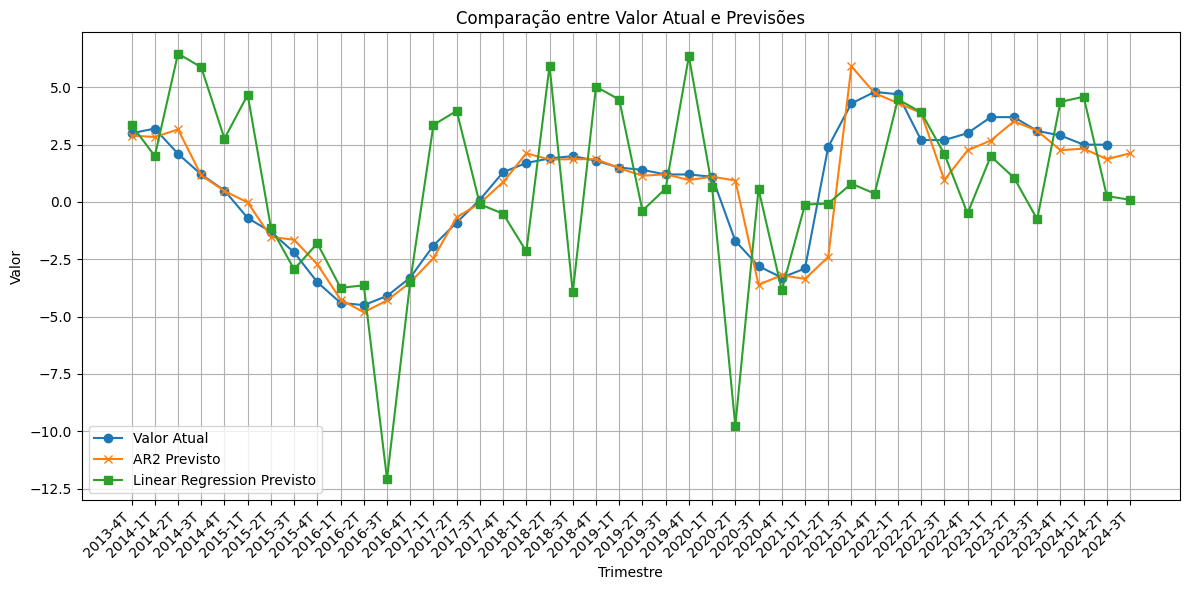

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Assuming df_agrupado is your DataFrame with 'trimestre', 'Valor', and 'Vetor Médio' columns

window_size = 42
forecasts = {'AR2': [], 'LinearRegression': []}

for i in range(window_size, len(df_agrupado) - 1):
    train_data = df_agrupado.iloc[i - window_size:i]
    test_data = df_agrupado.iloc[i:i + 1]
    y_train, y_test = train_data['Valor'], test_data['Valor']
    X_train = np.array(train_data['Vetor Médio'].tolist()).reshape(len(train_data), -1)
    X_test = np.array(test_data['Vetor Médio'].tolist()).reshape(len(test_data), -1)

    try:
        forecasts['AR2'].extend(AutoReg(y_train, lags=2, trend='n', seasonal=False).fit().predict(start=len(y_train), end=len(y_train)))
    except ValueError:
        forecasts['AR2'].extend([np.nan])

    forecasts['LinearRegression'].extend(LinearRegression().fit(X_train, y_train).predict(X_test))

for model_name, predicted_values in forecasts.items():
    diff = len(df_agrupado['Valor'][window_size:]) - len(predicted_values)
    actual_values = df_agrupado['Valor'][window_size: len(df_agrupado['Valor']) - diff].to_numpy()
    valid_indices = ~np.isnan(predicted_values) & ~np.isnan(actual_values)  # Filter for both
    predicted_values = np.array(predicted_values)
    mse = mean_squared_error(actual_values[valid_indices], predicted_values[valid_indices])
    print(f'{model_name} MSE: {mse}')

# Calculate the difference in length
diff = len(df_agrupado['Valor'][window_size:]) - len(forecasts['AR2'])  # Or forecasts['LinearRegression']

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'trimestre': df_agrupado['trimestre'][window_size:len(df_agrupado['trimestre']) - diff],  # Adjusted slicing
    'Valor_Atual': df_agrupado['Valor'][window_size:len(df_agrupado['Valor']) - diff],  # Adjusted slicing
    'AR2_Previsto': forecasts['AR2'],
    'LinearRegression_Previsto': forecasts['LinearRegression']
})

print(results_df)

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(results_df['trimestre'], results_df['Valor_Atual'], label='Valor Atual', marker='o')
plt.plot(results_df['trimestre'], results_df['AR2_Previsto'], label='AR2 Previsto', marker='x')
plt.plot(results_df['trimestre'], results_df['LinearRegression_Previsto'], label='Linear Regression Previsto', marker='s')

# Customize the plot
plt.xlabel('Trimestre')
plt.ylabel('Valor')
plt.title('Comparação entre Valor Atual e Previsões')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


                                                        Link  \
trimestre                                                      
2003Q2     https://www.bcb.gov.br/en/publications/copommi...   
2003Q3     https://www.bcb.gov.br/en/publications/copommi...   
2003Q4     https://www.bcb.gov.br/en/publications/copommi...   
2004Q1     https://www.bcb.gov.br/en/publications/copommi...   
2004Q2     https://www.bcb.gov.br/en/publications/copommi...   
...                                                      ...   
2023Q2     https://www.bcb.gov.br/en/publications/copommi...   
2023Q3     https://www.bcb.gov.br/en/publications/copommi...   
2023Q4     https://www.bcb.gov.br/en/publications/copommi...   
2024Q1     https://www.bcb.gov.br/en/publications/copommi...   
2024Q2     https://www.bcb.gov.br/en/publications/copommi...   

                                                       Texto  \
trimestre                                                      
2003Q2     85th Copom minutes - June 20

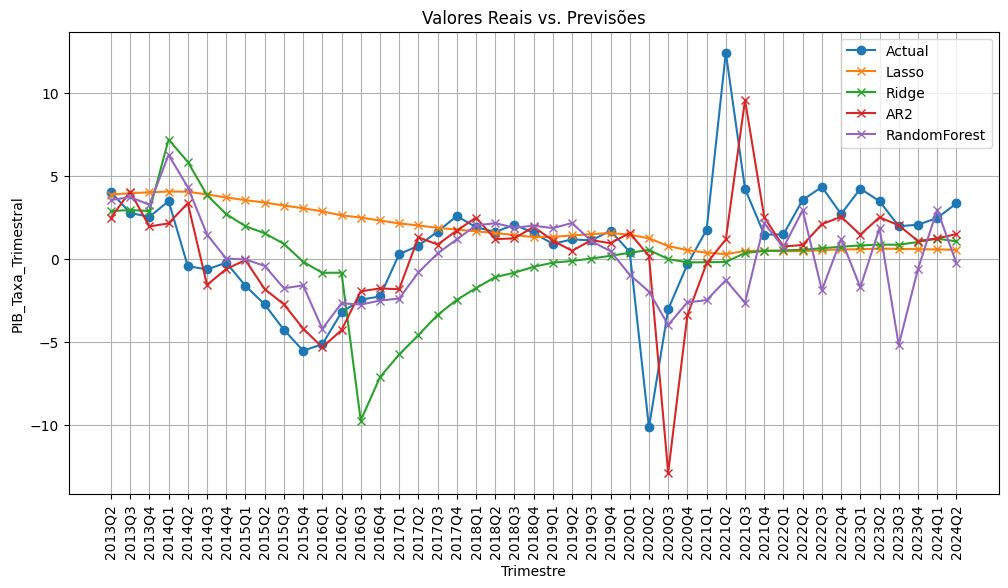

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Descartar as observações onde a coluna 'Valor' é missing (NaN)
df_final_cleaned = df_final_pca.dropna(subset=['PIB_Taxa_Trimestral'])
df_final_cleaned.loc[:, 'trimestre'] = pd.PeriodIndex(df_final_cleaned['trimestre'], freq='Q')
df_final_cleaned = df_final_cleaned.set_index('trimestre')  # Set 'trimestre' as index

variavelX = 'PCA'
variavelX2 = 'Vetor Médio'
variavelX3 = 'PIB_Taxa_Trimestral_lag1'
variavelX4 ='PIB_Taxa_Trimestral_lag2'
variavelY = 'PIB_Taxa_Trimestral'

# Definir o tamanho da janela deslizante
window_size = 15  # Ajustar conforme necessário

# Criar um dicionário vazio para armazenar os resultados das previsões para cada modelo
forecasts = {}

# Dicionário para armazenar resumos dos modelos
model_summaries = {}

# Iterar sobre os modelos
for model_name in ['LinearRegression', 'Lasso', 'Ridge', 'AR2', 'RandomForest']:
    forecasts[model_name] = []
    model_summaries[model_name] = []  # Inicializando a lista para armazenar resumos de cada modelo

    # Loop da janela deslizante
    for i in range(window_size, len(df_final_cleaned)):
        # Obter os dados de treinamento e teste para a janela atual
        train_data = df_final_cleaned.iloc[i - window_size:i]
        test_data = df_final_cleaned.iloc[i:i + 1]  # Previsão para o próximo timestamp

        # Preparar as características e a variável alvo
        X_train = np.array(train_data[variavelX].tolist()).reshape(len(train_data), -1)
        X_test = np.array(test_data[variavelX].tolist()).reshape(len(test_data), -1)
        X_train2 = np.array(train_data[variavelX2].tolist()).reshape(len(train_data), -1)
        X_test2 = np.array(test_data[variavelX2].tolist()).reshape(len(test_data), -1)

        y_train = train_data[variavelY]
        y_test = test_data[variavelY]

        # Criar e treinar o modelo de acordo com o nome do modelo
        if model_name == 'AR2':
            try:
                model = AutoReg(y_train, lags=2, trend='n', seasonal=False).fit()  # Removed old='nc'
                forecast = model.predict(start=len(y_train), end=len(y_train))  # Prever 1 passo à frente
                model_summaries[model_name].append({'Model': model_name, 'Params': model.params})
            except ValueError:
                forecast = [np.nan]  # Ou qualquer outro manuseio apropriado para erros
        elif model_name == 'Lasso':
            model = Lasso(alpha=0.01).fit(X_train2, y_train)
            forecast = model.predict(X_test2)
            model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_})
        elif model_name == 'Ridge':
            model = Ridge(alpha=100).fit(X_train2, y_train)
            forecast = model.predict(X_test2)
            model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_})
        elif model_name == 'RandomForest':
            model = RandomForestRegressor().fit(X_train2, y_train)
            forecast = model.predict(X_test2)
            model_summaries[model_name].append({'Model': model_name, 'Feature Importances': model.feature_importances_})
        elif model_name == 'LinearRegression':
            model = LinearRegression().fit(X_train, y_train)
            forecast = model.predict(X_test)
            model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_, 'Intercept': model.intercept_})

        forecasts[model_name].extend(forecast)

# Avaliar os modelos usando o Erro Quadrático Médio (MSE)
for model_name in forecasts:
    # Calcular a diferença de comprimento
    diff = len(df_final_cleaned[variavelY][window_size:]) - len(forecasts[model_name])

    # Ajustar a variável alvo para coincidir com o comprimento das previsões, lidando com possíveis NaNs
    actual_values = df_final_cleaned[variavelY][window_size: len(df_final_cleaned[variavelY]) - diff]
    predicted_values_np = np.array(forecasts[model_name])

    # Remover NaNs para o cálculo do MSE
    valid_indices = ~np.isnan(predicted_values_np)
    actual_values = actual_values[valid_indices]
    predicted_values = predicted_values_np[valid_indices]

    mse = mean_squared_error(actual_values, predicted_values)
    print(f'{model_name} MSE: {mse}')

    # Exibir o resumo do modelo
    #print(f"Resumo do Modelo {model_name}:")
    #for summary in model_summaries[model_name]:
      #  print(summary)

# Criar uma lista para armazenar os dados para o DataFrame
data = []
# Iterar sobre o índice dos valores reais
for i in range(len(actual_values)):
    # Criar uma linha com valor real e previsões de todos os modelos
    row = {'Actual': actual_values.iloc[i]}  # Use iloc para acesso baseado em índice
    for model_name in forecasts:
        try:
            row[model_name] = forecasts[model_name][i]  # Use i para indexação da lista
        except IndexError:  # Manusear o erro IndexError se a lista de previsões for mais curta
            row[model_name] = np.nan  # Adicionar NaN se a previsão não estiver disponível para esse timestamp
    data.append(row)

# Criar o DataFrame
results_df = pd.DataFrame(data, index=actual_values.index)
# Exibir a tabela
print(results_df)

# Criar uma figura e eixos
fig, ax = plt.subplots(figsize=(12, 6))  # Ajuste o tamanho da figura conforme necessário

trimestres = results_df.index.to_series().astype(str).tolist()

# Plotar os valores reais
ax.plot(trimestres, actual_values.values, label='Actual', marker='o')

# Plotar as previsões de cada modelo
for model_name in forecasts:
    # Ajustar os valores previstos para coincidir com o comprimento dos valores reais
    predicted_values = forecasts[model_name][:len(actual_values)]
    ax.plot(trimestres, predicted_values, label=model_name, marker='x')

# Configurar os rótulos do gráfico e título
ax.set_xlabel('Trimestre')
ax.set_ylabel('PIB_Taxa_Trimestral')
ax.set_title('Valores Reais vs. Previsões')
ax.legend()
ax.grid(True)

# Rotacionar os rótulos do eixo X
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()

- ajeitar o pequeno erro
- escolher o melhor alpha automaticamente
- colocar o summary dos modelos

In [ ]:
# Exportando para Excel
output_excel = 'resultados.xlsx'
results_df.to_excel(output_excel, index=False)

# Download no Google Colab
files.download(output_excel)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

teste com selecao de melhor alpha

/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Melhor alpha para o modelo Lasso: 0.055908101825122285 com score 4.266743685352621
Melhor alpha para o modelo Lasso: 0.04641588833612782 com score 2.041859078309014
Melhor alpha para o modelo Lasso: 0.022051307399030457 com score 2.2632448198773263
Melhor alpha para o modelo Lasso: 0.0041320124001153384 com score 2.5243922153291027
Melhor alpha para o modelo Lasso: 0.015199110829529346 com score 3.717791090916196
Melhor alpha para o modelo Lasso: 0.018307382802953697 com score 2.697761176751103
Melhor alpha para o modelo Lasso: 0.002848035868435802 com score 1.9013107366316415
Melhor alpha para o modelo Lasso: 0.015199110829529346 com score 2.9764029419652323
Melhor alpha para o modelo Lasso: 0.012618568830660211 com score 4.020807733923585
Melhor alpha para o modelo Lasso: 0.010476157527896652 com score 10.420525609828038
Melhor alpha para o modelo Lasso: 0.0001 com score 4.06185831325269
Melhor alpha para o modelo Lasso: 0.0001 com score 13.60116575608787
Melhor alpha para o modelo L

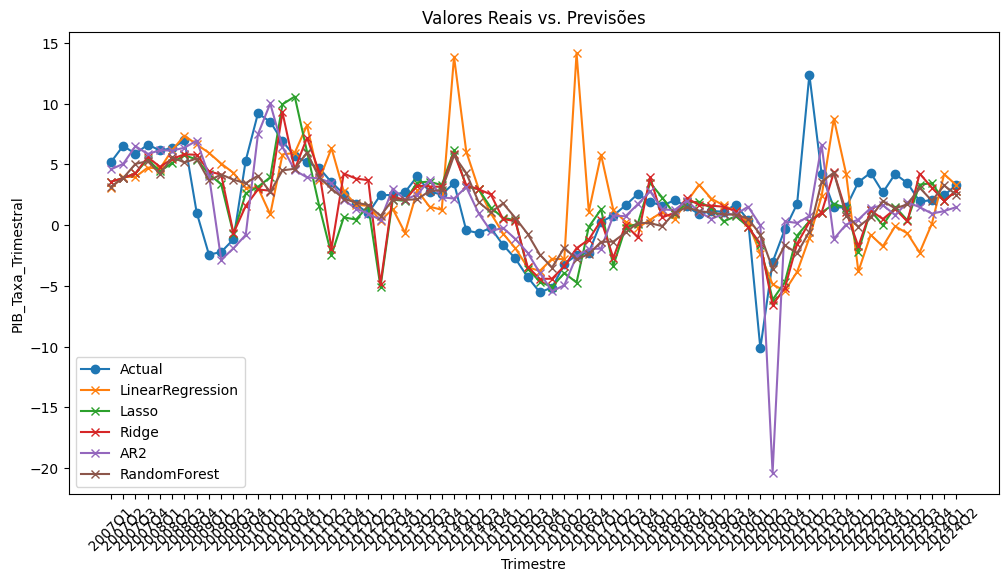

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import warnings

# Suprimir o aviso de ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Descartar as observações onde a coluna 'Valor' é missing (NaN)
df_final_cleaned = df_final_pca.dropna(subset=['PIB_Taxa_Trimestral'])
df_final_cleaned.loc[:, 'trimestre'] = pd.PeriodIndex(df_final_cleaned['trimestre'], freq='Q')
df_final_cleaned = df_final_cleaned.set_index('trimestre')  # Set 'trimestre' as index

variavelX = 'PCA'
variavelX2 = 'Vetor Médio'
variavelY = 'PIB_Taxa_Trimestral'

# Definir o tamanho da janela deslizante
window_size = 15  # Ajustar conforme necessário

# Criar um dicionário vazio para armazenar os resultados das previsões para cada modelo
forecasts = {}

# Dicionário para armazenar resumos dos modelos
model_summaries = {}

# Função para realizar GridSearchCV com TimeSeriesSplit
def find_best_alpha_with_tscv(model_name, X_train, y_train):
    # Definindo o modelo
    if model_name == 'Lasso':
        model = Lasso()
    elif model_name == 'Ridge':
        model = Ridge()

    # Definindo o intervalo de alphas
    param_grid = {'alpha': np.logspace(-4, 4, 100)}  # Usando uma gama mais ampla para alpha

    # TimeSeriesSplit para séries temporais
    tscv = TimeSeriesSplit(n_splits=5)  # Número de divisões

    # Realizando a busca em grid com validação cruzada
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Retorna o melhor alpha encontrado e o melhor score
    best_alpha = grid_search.best_params_['alpha']
    best_score = -grid_search.best_score_  # O scoring é negativo porque o GridSearchCV busca maximizar a pontuação, então invertendo o sinal obtemos o MSE
    return best_alpha, best_score

# Iterar sobre os modelos
for model_name in ['LinearRegression', 'Lasso', 'Ridge', 'AR2', 'RandomForest']:
    forecasts[model_name] = []
    model_summaries[model_name] = []  # Inicializando a lista para armazenar resumos de cada modelo

    # Loop da janela deslizante
    for i in range(window_size, len(df_final_cleaned)):
        # Obter os dados de treinamento e teste para a janela atual
        train_data = df_final_cleaned.iloc[i - window_size:i]
        test_data = df_final_cleaned.iloc[i:i + 1]  # Previsão para o próximo timestamp

        # Preparar as características e a variável alvo
        X_train = np.array(train_data[variavelX].tolist()).reshape(len(train_data), -1)
        X_test = np.array(test_data[variavelX].tolist()).reshape(len(test_data), -1)
        X_train2 = np.array(train_data[variavelX2].tolist()).reshape(len(train_data), -1)
        X_test2 = np.array(test_data[variavelX2].tolist()).reshape(len(test_data), -1)

        y_train = train_data[variavelY]
        y_test = test_data[variavelY]

        # Criar e treinar o modelo de acordo com o nome do modelo
        if model_name == 'AR2':
            try:
                model = AutoReg(y_train, lags=2, trend='n', seasonal=False).fit()  # Removed old='nc'
                forecast = model.predict(start=len(y_train), end=len(y_train))  # Prever 1 passo à frente
                model_summaries[model_name].append({'Model': model_name, 'Params': model.params})
            except ValueError:
                forecast = [np.nan]  # Ou qualquer outro manuseio apropriado para erros
        elif model_name == 'Lasso':
            # Encontrar o melhor alpha usando TimeSeriesSplit e GridSearchCV
            best_alpha_value, best_score = find_best_alpha_with_tscv(model_name, X_train2, y_train)
            print(f"Melhor alpha para o modelo Lasso: {best_alpha_value} com score {best_score}")

            # Criar e treinar o modelo com o melhor alpha encontrado
            model = Lasso(alpha=best_alpha_value).fit(X_train2, y_train)
            forecast = model.predict(X_test2)
            model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_, 'Alpha': best_alpha_value})
        elif model_name == 'Ridge':
            # Encontrar o melhor alpha usando TimeSeriesSplit e GridSearchCV
            best_alpha_value, best_score = find_best_alpha_with_tscv(model_name, X_train2, y_train)
            print(f"Melhor alpha para o modelo Ridge: {best_alpha_value} com score {best_score}")

            # Criar e treinar o modelo com o melhor alpha encontrado
            model = Ridge(alpha=best_alpha_value).fit(X_train2, y_train)
            forecast = model.predict(X_test2)
            model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_, 'Alpha': best_alpha_value})
        elif model_name == 'RandomForest':
            model = RandomForestRegressor().fit(X_train2, y_train)
            forecast = model.predict(X_test2)
            model_summaries[model_name].append({'Model': model_name, 'Feature Importances': model.feature_importances_})
        elif model_name == 'LinearRegression':
            model = LinearRegression().fit(X_train, y_train)
            forecast = model.predict(X_test)
            model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_, 'Intercept': model.intercept_})

        forecasts[model_name].extend(forecast)

# Avaliar os modelos usando o Erro Quadrático Médio (MSE)
for model_name in forecasts:
    # Calcular a diferença de comprimento
    diff = len(df_final_cleaned[variavelY][window_size:]) - len(forecasts[model_name])

    # Ajustar a variável alvo para coincidir com o comprimento das previsões, lidando com possíveis NaNs
    actual_values = df_final_cleaned[variavelY][window_size: len(df_final_cleaned[variavelY]) - diff]
    predicted_values_np = np.array(forecasts[model_name])

    # Remover NaNs para o cálculo do MSE
    valid_indices = ~np.isnan(predicted_values_np)
    actual_values = actual_values[valid_indices]
    predicted_values = predicted_values_np[valid_indices]

    mse = mean_squared_error(actual_values, predicted_values)
    print(f'{model_name} MSE: {mse}')

    # Exibir o resumo do modelo
   # print(f"Resumo do Modelo {model_name}:")
 #   for summary in model_summaries[model_name]:
      #  print(summary)

# Criar uma lista para armazenar os dados para o DataFrame
data = []
# Iterar sobre o índice dos valores reais
for i in range(len(actual_values)):
    # Criar uma linha com valor real e previsões de todos os modelos
    row = {'Actual': actual_values.iloc[i]}  # Use iloc para acesso baseado em índice
    for model_name in forecasts:
        try:
            row[model_name] = forecasts[model_name][i]  # Use i para indexação da lista
        except IndexError:  # Manusear o erro IndexError se a lista de previsões for mais curta
            row[model_name] = np.nan  # Adicionar NaN se a previsão não estiver disponível para esse timestamp
    data.append(row)

# Criar o DataFrame
results_df = pd.DataFrame(data, index=actual_values.index)
# Exibir a tabela
print(results_df)

# Criar uma figura e eixos
fig, ax = plt.subplots(figsize=(12, 6))  # Ajuste o tamanho da figura conforme necessário

trimestres = results_df.index.to_series().astype(str).tolist()

# Plotar os valores reais
ax.plot(trimestres, actual_values.values, label='Actual', marker='o')

# Plotar as previsões de cada modelo
for model_name in forecasts:
     #Ajustar os valores previstos para coincidir com o comprimento dos valores reais
     predicted_values = forecasts[model_name][:len(actual_values)]
     ax.plot(trimestres, predicted_values, label=model_name, marker='x')

# Configurar os rótulos do gráfico e título
ax.set_xlabel('Trimestre')
ax.set_ylabel('PIB_Taxa_Trimestral')
ax.set_title('Valores Reais vs. Previsões')
ax.legend()

# Exibir o gráfico
plt.xticks(rotation=45)
plt.show()


testes com varios periodos

/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


LinearRegression MSE: 16.093812981747377
Lasso MSE: 15.125177626347815
Ridge MSE: 10.96945868194113
AR2 MSE: 11.087906830388297
RandomForest MSE: 11.336420909943794
             Actual  LinearRegression     Lasso     Ridge       AR2  \
trimestre                                                             
2007Q1     5.194691          4.310867  4.033386  3.761141  4.601332   
2007Q2     6.537257          4.329679  4.176072  4.023466  5.047051   
2007Q3     5.870252          4.619771  4.337804  4.335454  6.507292   
2007Q4     6.639735          4.887942  4.727746  4.674541  5.863998   
2008Q1     6.157404          5.954802  5.541999  5.021403  6.168188   
...             ...               ...       ...       ...       ...   
2023Q2     3.468068         -1.068011 -0.815839  1.245210  1.884850   
2023Q3     1.959727         -0.279682 -0.204949  1.547562  1.487175   
2023Q4     2.053173          3.271098  3.010509  1.767863  0.955609   
2024Q1     2.456020          8.065403  7.400137  2.051

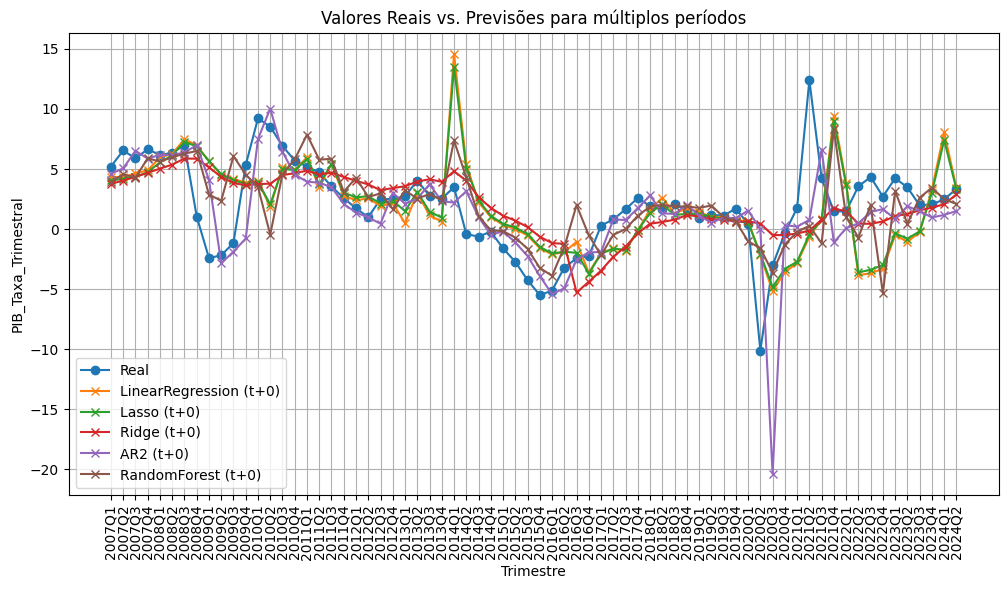

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Descartar as observações onde a coluna 'PIB_Taxa_Trimestral' é missing (NaN)
df_final_cleaned = df_final_pca.dropna(subset=['PIB_Taxa_Trimestral'])
df_final_cleaned.loc[:, 'trimestre'] = pd.PeriodIndex(df_final_cleaned['trimestre'], freq='Q')
df_final_cleaned = df_final_cleaned.set_index('trimestre')  # Set 'trimestre' as index

variavelX = 'PCA'
variavelY = 'PIB_Taxa_Trimestral'

# Definir o número de períodos a serem previstos (n períodos)
n_periodos = 1  # Número de períodos a serem previstos

# Definir o tamanho da janela deslizante
window_size = 15  # Ajustar conforme necessário

# Criar um dicionário vazio para armazenar os resultados das previsões para cada modelo
forecasts = {model_name: [] for model_name in ['LinearRegression', 'Lasso', 'Ridge', 'AR2', 'RandomForest']}

# Iterar pelos modelos
for model_name in forecasts:
    # Loop de janela deslizante
    for i in range(window_size, len(df_final_cleaned) - n_periodos + 1):
        # Obter os dados de treino e teste para a janela atual
        train_data = df_final_cleaned.iloc[i - window_size:i]
        test_data = df_final_cleaned.iloc[i:i + n_periodos]  # Forecast para os próximos n períodos

        # Preparar as variáveis de entrada e a variável de destino
        X_train = np.array(train_data[variavelX].tolist()).reshape(len(train_data), -1)
        X_test = np.array(test_data[variavelX].tolist()).reshape(len(test_data), -1)
        y_train = train_data[variavelY]
        y_test = test_data[variavelY]

        # Criar e treinar o modelo de acordo com o nome do modelo
        if model_name == 'AR2':
            try:
                model = AutoReg(y_train, lags=2, trend='n', seasonal=False).fit()
                forecast = model.predict(start=len(y_train), end=len(y_train) + n_periodos - 1)  # Prever n períodos
            except ValueError:
                forecast = [np.nan] * n_periodos  # Prever n períodos com NaN
        elif model_name == 'Lasso':
            model = Lasso(alpha=0.1).fit(X_train, y_train)
            forecast = model.predict(X_test)
        elif model_name == 'Ridge':
            model = Ridge(alpha=100).fit(X_train, y_train)
            forecast = model.predict(X_test)
        elif model_name == 'RandomForest':
            model = RandomForestRegressor().fit(X_train, y_train)
            forecast = model.predict(X_test)
        elif model_name == 'LinearRegression':
            model = LinearRegression().fit(X_train, y_train)
            forecast = model.predict(X_test)

        # Armazenar as previsões de maneira consistente
        forecasts[model_name].extend(forecast)

# Avaliar os modelos usando o erro quadrático médio (MSE)
for model_name in forecasts:
    # Ajustar a variável alvo para coincidir com o comprimento da previsão, lidando com NaNs
    actual_values = df_final_cleaned[variavelY][window_size: len(df_final_cleaned[variavelY])]

    # Garantir que forecasts seja uma lista de valores
    predicted_values_np = np.array(forecasts[model_name])

    # Ajustar a previsão para ter o mesmo comprimento de actual_values
    if len(predicted_values_np) != len(actual_values):
        predicted_values_np = predicted_values_np[:len(actual_values)]  # Cortar ou extrapolar

    # Remover NaNs para cálculo do MSE
    valid_indices = ~np.isnan(predicted_values_np)

    try:
        # Ajustar os valores reais e as previsões com base na máscara de valores válidos
        actual_values = actual_values[valid_indices]
        predicted_values = predicted_values_np[valid_indices]

        # Calcular o MSE
        mse = mean_squared_error(actual_values, predicted_values)
        print(f'{model_name} MSE: {mse}')
    except IndexError:
        print(f"Erro de indexação para o modelo {model_name}. Tamanho dos dados reais: {len(actual_values)}, tamanho das previsões: {len(predicted_values_np)}")

# Criar uma lista para armazenar os dados para o DataFrame
data = []

# Iterar pelo índice dos valores reais
for i in range(len(actual_values)):
    # Criar uma linha com o valor real e as previsões de todos os modelos
    row = {'Actual': actual_values.iloc[i]}  # Usar iloc para acessar por índice
    for model_name in forecasts:
        try:
            row[model_name] = forecasts[model_name][i]  # Usar i para indexar a lista de previsões
        except IndexError:  # Lidar com IndexError se a lista de previsões for mais curta
            row[model_name] = np.nan  # Adicionar NaN se a previsão não estiver disponível para esse timestamp
    data.append(row)

# Criar o DataFrame
results_df = pd.DataFrame(data, index=actual_values.index)
# Exibir a tabela
print(results_df)

# Criar uma figura e os eixos para o gráfico
fig, ax = plt.subplots(figsize=(12, 6))  # Ajuste do tamanho da figura conforme necessário

trimestres = results_df.index.to_series().astype(str).tolist()

# Plotar os valores reais
ax.plot(trimestres, actual_values.values, label='Real', marker='o')

# Plotar as previsões de cada modelo para múltiplos períodos
for model_name in forecasts:
    for j in range(n_periodos):
        predicted_values = forecasts[model_name][j:len(actual_values) + j]
        ax.plot(trimestres, predicted_values, label=f'{model_name} (t+{j})', marker='x')

# Definir rótulos do gráfico e título
ax.set_xlabel('Trimestre')
ax.set_ylabel('PIB_Taxa_Trimestral')
ax.set_title('Valores Reais vs. Previsões para múltiplos períodos')
ax.legend()
ax.grid(True)

# Rotacionar os rótulos do eixo X
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()




LASSO OK

Index(['trimestre', 'Link', 'Texto', 'Link de Download', 'Texto do PDF',
       'Texto Processado', 'Ano_Mes', 'A', 'B', 'C', 'D', 'Footnotes',
       'Texto Processado2', 'PIB_Taxa_Trimestral',
       'PIB_Trimestre_Contra_Trimestre', 'PIB_Taxa_Trimestral_lag1',
       'PIB_Taxa_Trimestral_lag2', 'PIB_Trimestre_Contra_Trimestre_lag1',
       'PIB_Trimestre_Contra_Trimestre_lag2', 'Vetor Médio', 'PC1', 'PC2',
       'PC3', 'PCA'],
      dtype='object')
   trimestre                                        Vetor Médio  \
0     2003Q2  [-0.16271618, 0.21974215, -0.09200615, 0.08374...   
1     2003Q3  [-0.16491212, 0.22819252, -0.07643579, 0.07215...   
2     2003Q4  [-0.13151231, 0.23075606, -0.08599814, 0.07290...   
3     2004Q1  [-0.1919001, 0.24167468, -0.07850038, 0.097063...   
4     2004Q2  [-0.18287906, 0.25966114, -0.081189476, 0.0728...   
..       ...                                                ...   
80    2023Q2  [-0.17821713, 0.22676949, 0.047519106, 0.16764...   
81    2

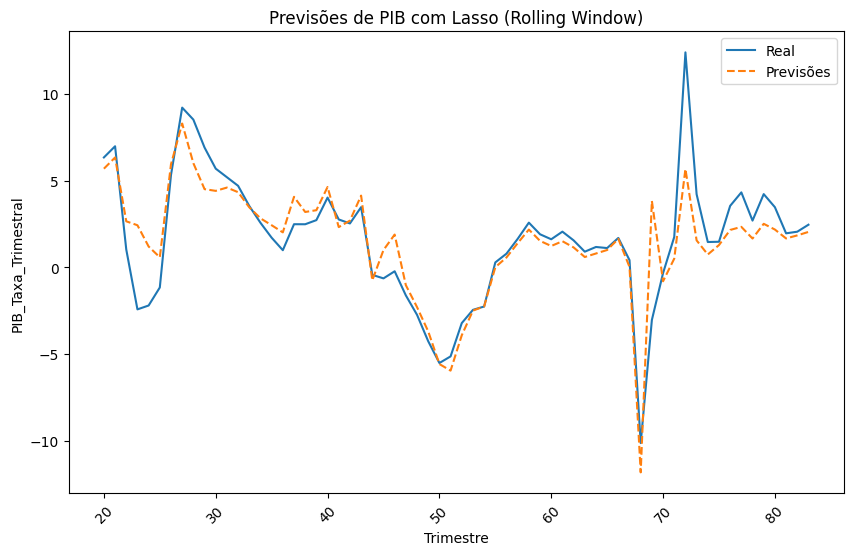

"\n\n\n# Função para criar as defasagens\ndef create_lags(y, lags=2):\n    lags_data = pd.DataFrame({f'y_lag_{i}': y.shift(i) for i in range(1, lags + 1)})\n    return lags_data\n\n# Iterar sobre os modelos\nfor model_name in ['LinearRegression', 'Lasso', 'Ridge', 'AR2', 'RandomForest']:\n    forecasts[model_name] = []\n    model_summaries[model_name] = []  # Inicializando a lista para armazenar resumos de cada modelo\n\n    # Loop da janela deslizante\n    for i in range(window_size, len(df_final_cleaned)):\n        # Obter os dados de treinamento e teste para a janela atual\n        train_data = df_final_cleaned.iloc[i - window_size:i]\n        test_data = df_final_cleaned.iloc[i:i + 1]  # Previsão para o próximo timestamp\n\n        # Preparar as características e a variável alvo\n        X_train = np.array(train_data[variavelX].tolist()).reshape(len(train_data), -1)\n        X_test = np.array(test_data[variavelX].tolist()).reshape(len(test_data), -1)\n        X_train2 = np.array(tr

In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

print(df_final_pca.columns)

# Criando um DF com os nomes das colunas desejadas
colunas_selecionadas = ['trimestre', 'Vetor Médio', 'PIB_Taxa_Trimestral','PIB_Taxa_Trimestral_lag1', 'PIB_Taxa_Trimestral_lag2']
df_final_cleaned = df_final_pca[colunas_selecionadas]


# Remover todas as observações (linhas) que contenham NaN em qualquer coluna
df_final_cleaned = df_final_cleaned.dropna()

print(df_final_cleaned)
print(type(df_final_cleaned['Vetor Médio'].iloc[0]))

# Tamanho da janela (rolling window) e número de períodos a prever
window_size = 20  # Tamanho da janela de treino
forecast_periods = 1  # Prever 1 período à frente (próximo trimestre)

# Função para realizar a previsão usando Lasso com janela deslizante
def rolling_lasso(df, window_size, forecast_periods):
    forecasts = []
    coefficients = []

    # Expansão do vetor médio em variáveis separadas (dimensões 1 a 300)
    vetor_medio_columns = [f'Vetor_Medio_{i}' for i in range(300)]
    df_vetor_medio_expanded = pd.DataFrame(df['Vetor Médio'].tolist(), columns=vetor_medio_columns)

    # Juntando os dados expandidos com as variáveis defasadas
    df_expanded = pd.concat([df_vetor_medio_expanded, df[['PIB_Taxa_Trimestral_lag1', 'PIB_Taxa_Trimestral_lag2']]], axis=1)

    for i in range(window_size, len(df) - forecast_periods):
        # Dividir os dados de treino e teste com base na janela
        train_data = df_expanded.iloc[i - window_size:i]
        test_data = df.iloc[i + forecast_periods:i + forecast_periods + 1]

        # Definir as variáveis independentes (X) e dependentes (y)
        X_train = train_data.values  # X será todo o DataFrame expandido (vetores + defasagens)
        y_train = df['PIB_Taxa_Trimestral'].iloc[i - window_size:i].values

        # Aplique a concatenação corretamente
        X_test = np.concatenate([test_data['Vetor Médio'].iloc[0],
                         [test_data['PIB_Taxa_Trimestral_lag1'].iloc[0],
                          test_data['PIB_Taxa_Trimestral_lag2'].iloc[0]]])
        X_test = X_test.reshape(1, -1)

        # Verificar a forma de X_test
        print(f"Forma de X_test: {X_test.shape}")

        y_test = test_data['PIB_Taxa_Trimestral'].values

        # Verifique a forma de X_test antes de passá-lo para o modelo
        print("Forma de X_test:", X_test.shape)

        # Criar o modelo Lasso e treinar com a janela de treino
        model = Lasso(alpha=0.1)  # Alpha pode ser ajustado para regularização
        model.fit(X_train, y_train)

        # Fazer a previsão
        forecast = model.predict(X_test)

        # Armazenar a previsão e os coeficientes
        forecasts.append(forecast[0])
        coefficients.append(model.coef_)

    return forecasts, coefficients

# Realizar a previsão e calcular os coeficientes
forecasts, coefficients = rolling_lasso(df_final_cleaned, window_size, forecast_periods)

# Criar a série temporal das previsões
actual_values = df_final_cleaned['PIB_Taxa_Trimestral'].iloc[window_size:len(forecasts) + window_size]

# Calcular o MSE
mse = mean_squared_error(actual_values, forecasts)
print(f'Mean Squared Error (MSE): {mse}')

# Exibir os coeficientes do modelo Lasso
print("Coeficientes do modelo Lasso:")
coef_df = pd.DataFrame(coefficients, columns=[f'Coef_Vetor_Medio_{i}' for i in range(300)] + ['PIB_Taxa_Trimestral_lag1', 'PIB_Taxa_Trimestral_lag2'])
print(coef_df)

# Plotar os resultados (valores reais vs previsões)
plt.figure(figsize=(10, 6))
plt.plot(actual_values.index, actual_values.values, label='Real')
plt.plot(actual_values.index, forecasts, label='Previsões', linestyle='--')
plt.xlabel('Trimestre')
plt.ylabel('PIB_Taxa_Trimestral')
plt.title('Previsões de PIB com Lasso (Rolling Window)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

"""


# Função para criar as defasagens
def create_lags(y, lags=2):
    lags_data = pd.DataFrame({f'y_lag_{i}': y.shift(i) for i in range(1, lags + 1)})
    return lags_data

# Iterar sobre os modelos
for model_name in ['LinearRegression', 'Lasso', 'Ridge', 'AR2', 'RandomForest']:
    forecasts[model_name] = []
    model_summaries[model_name] = []  # Inicializando a lista para armazenar resumos de cada modelo

    # Loop da janela deslizante
    for i in range(window_size, len(df_final_cleaned)):
        # Obter os dados de treinamento e teste para a janela atual
        train_data = df_final_cleaned.iloc[i - window_size:i]
        test_data = df_final_cleaned.iloc[i:i + 1]  # Previsão para o próximo timestamp

        # Preparar as características e a variável alvo
        X_train = np.array(train_data[variavelX].tolist()).reshape(len(train_data), -1)
        X_test = np.array(test_data[variavelX].tolist()).reshape(len(test_data), -1)
        X_train2 = np.array(train_data[variavelX2].tolist()).reshape(len(train_data), -1)
        X_test2 = np.array(test_data[variavelX2].tolist()).reshape(len(test_data), -1)

        y_train = train_data[variavelY]
        y_test = test_data[variavelY]

        # Criar lags de y_train (AR(2))
        y_train_lags = create_lags(y_train, lags=2)
        X_train_with_lags = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train2), y_train_lags], axis=1).dropna()
        X_test_with_lags = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test2), create_lags(y_test, lags=2)], axis=1).dropna()

        # Verificar se há dados suficientes para treinar o modelo
        if X_train_with_lags.shape[0] > 0 and X_test_with_lags.shape[0] > 0:
            # Converter os nomes das colunas para strings
            X_train_with_lags.columns = X_train_with_lags.columns.astype(str)
            X_test_with_lags.columns = X_test_with_lags.columns.astype(str)

            # Criar e treinar o modelo de acordo com o nome do modelo
            if model_name == 'AR2':
                try:
                    model = AutoReg(y_train, lags=2, trend='n', seasonal=False).fit()  # Removed old='nc'
                    forecast = model.predict(start=len(y_train), end=len(y_train))  # Prever 1 passo à frente
                    model_summaries[model_name].append({'Model': model_name, 'Params': model.params})
                except ValueError:
                    forecast = [np.nan]  # Ou qualquer outro manuseio apropriado para erros
            elif model_name == 'Lasso':
                model = Lasso(alpha=0.01).fit(X_train_with_lags, y_train)
                forecast = model.predict(X_test_with_lags)
                model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_})
            elif model_name == 'Ridge':
                model = Ridge(alpha=100).fit(X_train_with_lags, y_train)
                forecast = model.predict(X_test_with_lags)
                model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_})
            elif model_name == 'RandomForest':
                model = RandomForestRegressor().fit(X_train_with_lags, y_train)
                forecast = model.predict(X_test_with_lags)
                model_summaries[model_name].append({'Model': model_name, 'Feature Importances': model.feature_importances_})
            elif model_name == 'LinearRegression':
                model = LinearRegression().fit(X_train_with_lags, y_train)
                forecast = model.predict(X_test_with_lags)
                model_summaries[model_name].append({'Model': model_name, 'Coef': model.coef_, 'Intercept': model.intercept_})

            forecasts[model_name].extend(forecast)
        else:
            # Se não houver dados suficientes, adicione NaN
            forecasts[model_name].append(np.nan)

# Avaliar os modelos usando o Erro Quadrático Médio (MSE)
for model_name in forecasts:
    # Calcular a diferença de comprimento
    diff = len(df_final_cleaned[variavelY][window_size:]) - len(forecasts[model_name])

    # Ajustar a variável alvo para coincidir com o comprimento das previsões, lidando com possíveis NaNs
    actual_values = df_final_cleaned[variavelY][window_size: len(df_final_cleaned[variavelY]) - diff]
    predicted_values_np = np.array(forecasts[model_name])

    # Remover NaNs para o cálculo do MSE
    valid_indices = ~np.isnan(predicted_values_np)
    actual_values = actual_values[valid_indices]
    predicted_values = predicted_values_np[valid_indices]

    # Verificar se há pelo menos 1 valor válido para calcular o MSE
    if len(actual_values) > 0 and len(predicted_values) > 0:
        mse = mean_squared_error(actual_values, predicted_values)
        print(f'{model_name} MSE: {mse}')
    else:
        print(f'{model_name} não tem previsões válidas para calcular o MSE.')

# Criar uma lista para armazenar os dados para o DataFrame
data = []
# Iterar sobre o índice dos valores reais
for i in range(len(actual_values)):
    # Criar uma linha com valor real e previsões de todos os modelos
    row = {'Actual': actual_values.iloc[i]}  # Use iloc para acesso baseado em índice
    for model_name in forecasts:
        try:
            row[model_name] = forecasts[model_name][i]  # Use i para indexação da lista
        except IndexError:  # Manusear o erro IndexError se a lista de previsões for mais curta
            row[model_name] = np.nan  # Adicionar NaN se a previsão não estiver disponível para esse timestamp
    data.append(row)

# Criar o DataFrame
results_df = pd.DataFrame(data, index=actual_values.index)
# Exibir a tabela
print(results_df)

# Criar uma figura e eixos
fig, ax = plt.subplots(figsize=(12, 6))  # Ajuste o tamanho da figura conforme necessário

trimestres = results_df.index.to_series().astype(str).tolist()

# Plotar os valores reais
ax.plot(trimestres, actual_values.values, label='Actual', marker='o')

# Plotar as previsões de cada modelo
for model_name in forecasts:
    # Ajustar os valores previstos para coincidir com o comprimento dos valores reais
    predicted_values = forecasts[model_name][:len(actual_values)]
    ax.plot(trimestres, predicted_values, label=model_name, marker='x')

# Configurar os rótulos do gráfico e título
ax.set_xlabel('Trimestre')
ax.set_ylabel('PIB_Taxa_Trimestral')
ax.set_title('Valores Reais vs. Previsões')
ax.legend()
ax.grid(True)

# Rotacionar os rótulos do eixo X
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()
"""

LASSO X AR2 ok


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Mean Squared Error (MSE) - Lasso: 2.973821438181531
Mean Squared Error (MSE) - AR2: 11.080999028598377
Coeficientes do modelo Lasso:
    Coef_Vetor_Medio_0  Coef_Vetor_Medio_1  Coef_Vetor_Medio_2  \
0                  0.0                 0.0                -0.0   
1                  0.0                 0.0                -0.0   
2                  0.0                 0.0                 0.0   
3                  0.0                 0.0                -0.0   
4                  0.0                -0.0                -0.0   
..                 ...                 ...                 ...   
59                -0.0                 0.0                 0.0   
60                -0.0                 0.0                -0.0   
61                -0.0                 0.0                -0.0   
62                -0.0                 0.0                -0.0   
63                -0.0                 0.0                -0.0   

    Coef_Vetor_Medio_3  Coef_Vetor_Medio_4  Coef_Vetor_Medio_5  \
0       

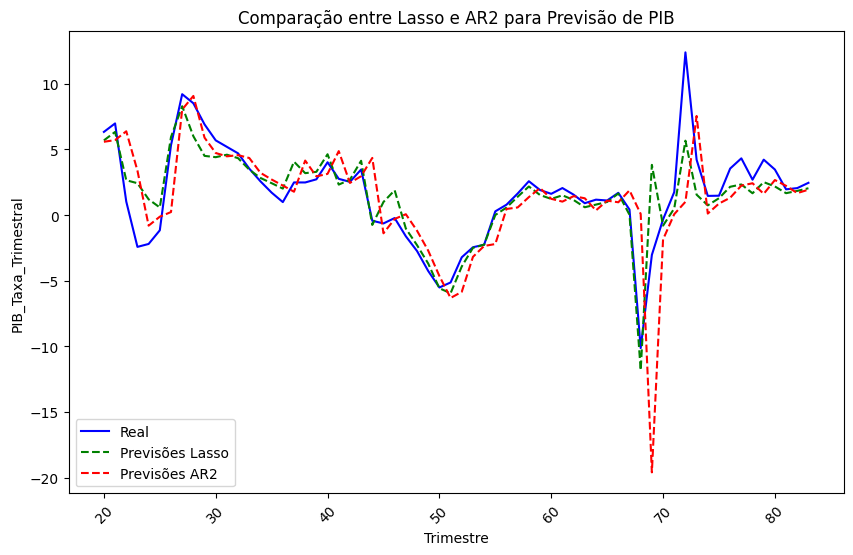

In [50]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Criando um DF com os nomes das colunas desejadas
colunas_selecionadas = ['trimestre', 'Vetor Médio', 'PIB_Taxa_Trimestral','PIB_Taxa_Trimestral_lag1', 'PIB_Taxa_Trimestral_lag2']
df_final_cleaned = df_final_pca[colunas_selecionadas]

# Remover todas as observações (linhas) que contenham NaN em qualquer coluna
df_final_cleaned = df_final_cleaned.dropna()

# Tamanho da janela (rolling window) e número de períodos a prever
window_size = 20  # Tamanho da janela de treino
forecast_periods = 1  # Prever 1 período à frente (próximo trimestre)

# Função para realizar a previsão usando Lasso e AR(2)
def rolling_forecast(df, window_size, forecast_periods, model):
    forecasts = []
    coefficients = []

    # Expansão do vetor médio em variáveis separadas (dimensões 1 a 300)
    vetor_medio_columns = [f'Vetor_Medio_{i}' for i in range(300)]
    df_vetor_medio_expanded = pd.DataFrame(df['Vetor Médio'].tolist(), columns=vetor_medio_columns)

    # Juntando os dados expandidos com as variáveis defasadas
    df_expanded = pd.concat([df_vetor_medio_expanded, df[['PIB_Taxa_Trimestral_lag1', 'PIB_Taxa_Trimestral_lag2']]], axis=1)

    for i in range(window_size, len(df) - forecast_periods):
        # Dividir os dados de treino e teste com base na janela
        train_data = df_expanded.iloc[i - window_size:i]
        test_data = df.iloc[i + forecast_periods:i + forecast_periods + 1]

        if model == 'lasso':
            # Definir as variáveis independentes (X) e dependentes (y)
            X_train = train_data.values  # X será todo o DataFrame expandido (vetores + defasagens)
            y_train = df['PIB_Taxa_Trimestral'].iloc[i - window_size:i].values

            # Aplique a concatenação corretamente
            X_test = np.concatenate([test_data['Vetor Médio'].iloc[0],
                         [test_data['PIB_Taxa_Trimestral_lag1'].iloc[0],
                          test_data['PIB_Taxa_Trimestral_lag2'].iloc[0]]])
            X_test = X_test.reshape(1, -1)  # Certifique-se de que X_test seja uma matriz 2D

            # Criar o modelo Lasso e treinar com a janela de treino
            model_lasso = Lasso(alpha=0.1)  # Alpha pode ser ajustado para regularização
            model_lasso.fit(X_train, y_train)

            # Fazer a previsão
            forecast = model_lasso.predict(X_test)[0]
            forecasts.append(forecast)
            coefficients.append(model_lasso.coef_)

        elif model == 'ar2':
            # Modelo AR(2)
            model_ar2 = AutoReg(df['PIB_Taxa_Trimestral'].iloc[i - window_size:i], lags=2)
            model_ar2_fit = model_ar2.fit()
            forecast_series = model_ar2_fit.forecast(steps=forecast_periods)

            # A previsão é uma pandas.Series. Acesse o primeiro valor usando .iloc[0]
            forecast = forecast_series.iloc[0]  # Ou .values[0] se preferir usar numpy array

            forecasts.append(forecast)
            coefficients.append(model_ar2_fit.params)

    return forecasts, coefficients

# Realizar a previsão para Lasso
lasso_forecasts, lasso_coefficients = rolling_forecast(df_final_cleaned, window_size, forecast_periods, 'lasso')

# Realizar a previsão para AR2
ar2_forecasts, ar2_coefficients = rolling_forecast(df_final_cleaned, window_size, forecast_periods, 'ar2')

# Criar a série temporal das previsões
# Corrigir o índice para evitar problemas de 'KeyError'
actual_values = df_final_cleaned['PIB_Taxa_Trimestral'].iloc[window_size:window_size + len(lasso_forecasts)]

# Calcular o MSE para Lasso
mse_lasso = mean_squared_error(actual_values, lasso_forecasts)
print(f'Mean Squared Error (MSE) - Lasso: {mse_lasso}')

# Calcular o MSE para AR2
mse_ar2 = mean_squared_error(actual_values, ar2_forecasts)
print(f'Mean Squared Error (MSE) - AR2: {mse_ar2}')

# Exibir os coeficientes do modelo Lasso
print("Coeficientes do modelo Lasso:")
coef_df_lasso = pd.DataFrame(lasso_coefficients, columns=[f'Coef_Vetor_Medio_{i}' for i in range(300)] + ['PIB_Taxa_Trimestral_lag1', 'PIB_Taxa_Trimestral_lag2'])
print(coef_df_lasso)

# Exibir os coeficientes do modelo AR2
print("Coeficientes do modelo AR2:")
coef_df_ar2 = pd.DataFrame(ar2_coefficients)
print(coef_df_ar2)

# Plotar os resultados (valores reais vs previsões)
plt.figure(figsize=(10, 6))
plt.plot(actual_values.index, actual_values.values, label='Real', color='blue')
plt.plot(actual_values.index, lasso_forecasts, label='Previsões Lasso', linestyle='--', color='green')
plt.plot(actual_values.index, ar2_forecasts, label='Previsões AR2', linestyle='--', color='red')
plt.xlabel('Trimestre')
plt.ylabel('PIB_Taxa_Trimestral')
plt.title('Comparação entre Lasso e AR2 para Previsão de PIB')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Sintonia fina de base pre treinada - esta so usando os vetores, nao esta treinando de novo!

In [ ]:
import numpy as np
from gensim.models import KeyedVectors, Word2Vec
import os
from google.colab import drive

drive.mount('/content/drive')

# Defina o caminho para os embeddings
embeddings_path = '/content/drive/My Drive/Caen/TESE/word2vec-google-news-300.model.vectors.npy'

# Carregar os vetores
vectors = np.load(embeddings_path)

# Tokenizar cada frase do seu DataFrame
corpus = df_final['Texto Processado'].tolist()
corpus = [text for text in corpus if isinstance(text, str) and text.strip() != ""]
tokenized_corpus = [sentence.split() for sentence in corpus]  # Tokenização simples

# Criar um novo modelo Word2Vec
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=1, sg=1)

# Construir o vocabulário do corpus
word2vec_model.build_vocab(tokenized_corpus)

# Inicializar os vetores do novo modelo com os vetores pré-treinados
for word in word2vec_model.wv.index_to_key:
    if word in vectors:  # Verifique se a palavra existe nos vetores
        word2vec_model.wv[word] = vectors[vectors.index(word)]  # Atribua o vetor pré-treinado

# Treinar o modelo no seu conjunto de dados
word2vec_model.train(tokenized_corpus, total_examples=len(tokenized_corpus), epochs=word2vec_model.epochs)

# Salvar o novo modelo
word2vec_model.save("/content/drive/My Drive/Caen/TESE/meu_modelo_fine_tuned_word2vec.model")